In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
%matplotlib inline
from pyvista import set_plot_theme
set_plot_theme('document')
import vtk
import os

Applying Textures {#ref_texture_example}
=================

Plot a mesh with an image projected onto it as a texture.


In [2]:
from matplotlib.cm import get_cmap
import numpy as np

import pyvista as pv
from pyvista import examples

Texture mapping is easily implemented using PyVista. Many of the
geometric objects come preloaded with texture coordinates, so quickly
creating a surface and displaying an image is simply:


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


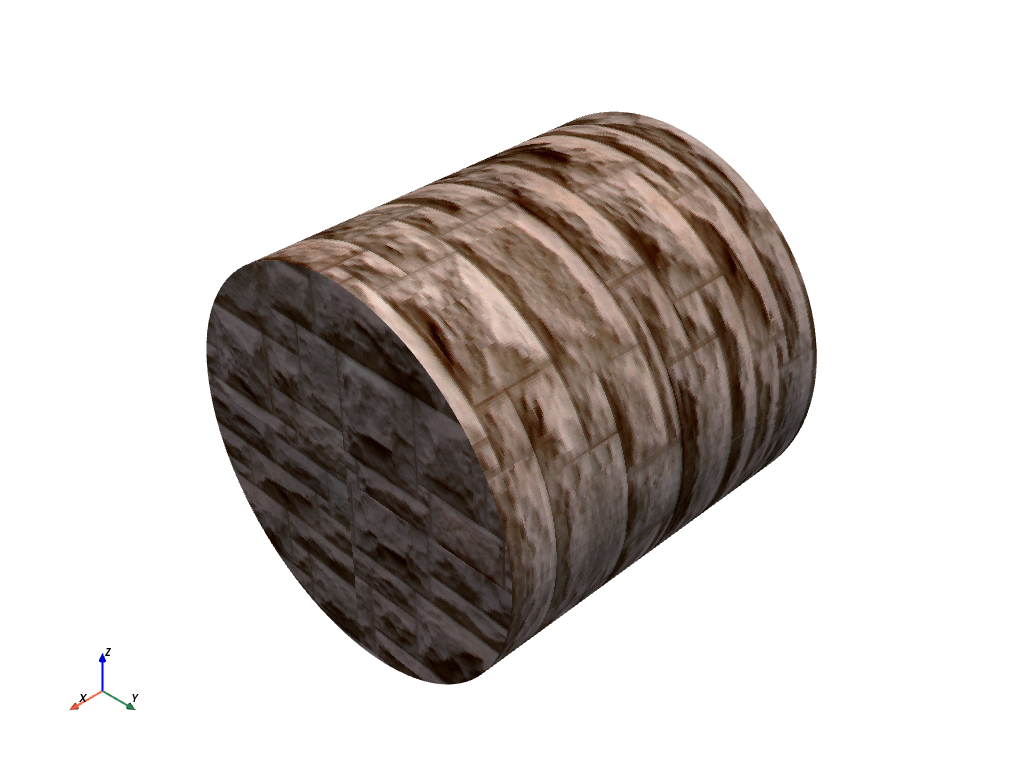

In [3]:
# load a sample texture
tex = examples.download_masonry_texture()

# create a surface to host this texture
surf = pv.Cylinder()

surf.plot(texture=tex)

But what if your dataset doesn\'t have texture coordinates? Then you can
harness the
`pyvista.DataSetFilters.texture_map_to_plane`{.interpreted-text
role="func"} filter to properly map an image to a dataset\'s surface.
For example, let\'s map that same image of bricks to a curvey surface:


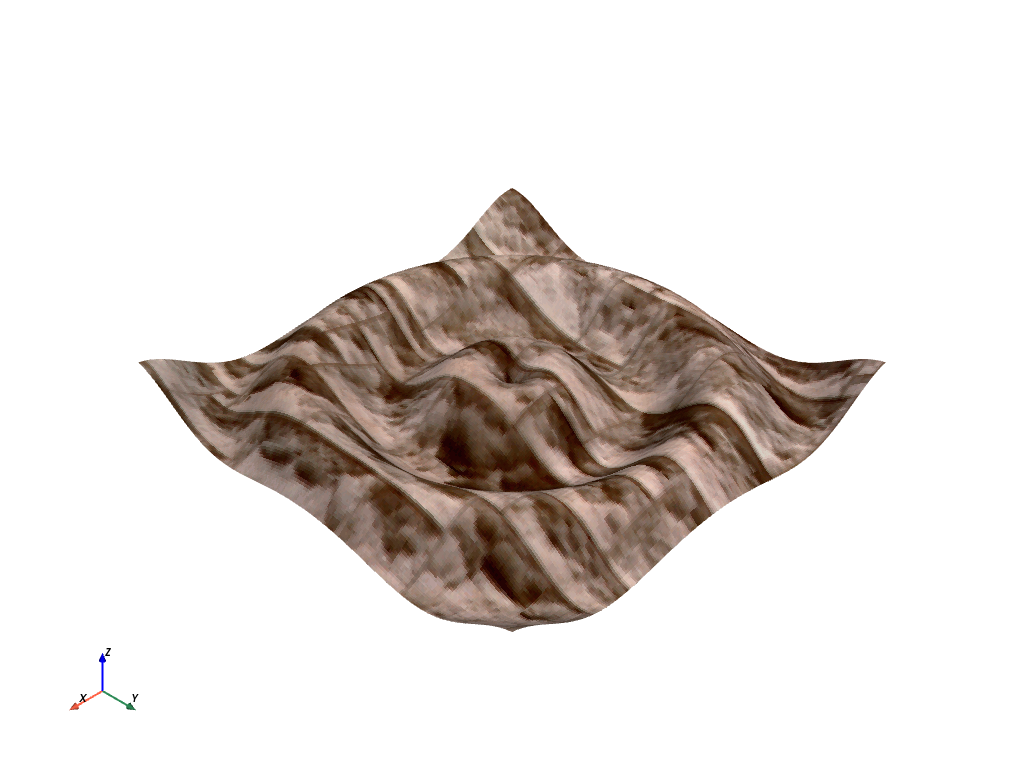

In [4]:
# create a structured surface
x = np.arange(-10, 10, 0.25)
y = np.arange(-10, 10, 0.25)
x, y = np.meshgrid(x, y)
r = np.sqrt(x**2 + y**2)
z = np.sin(r)
curvsurf = pv.StructuredGrid(x, y, z)

# Map the curved surface to a plane - use best fitting plane
curvsurf.texture_map_to_plane(inplace=True)

curvsurf.plot(texture=tex)

Display scalar data along with a texture by ensuring the
`interpolate_before_map` setting is `False` and specifying both the
`texture` and `scalars` arguments.


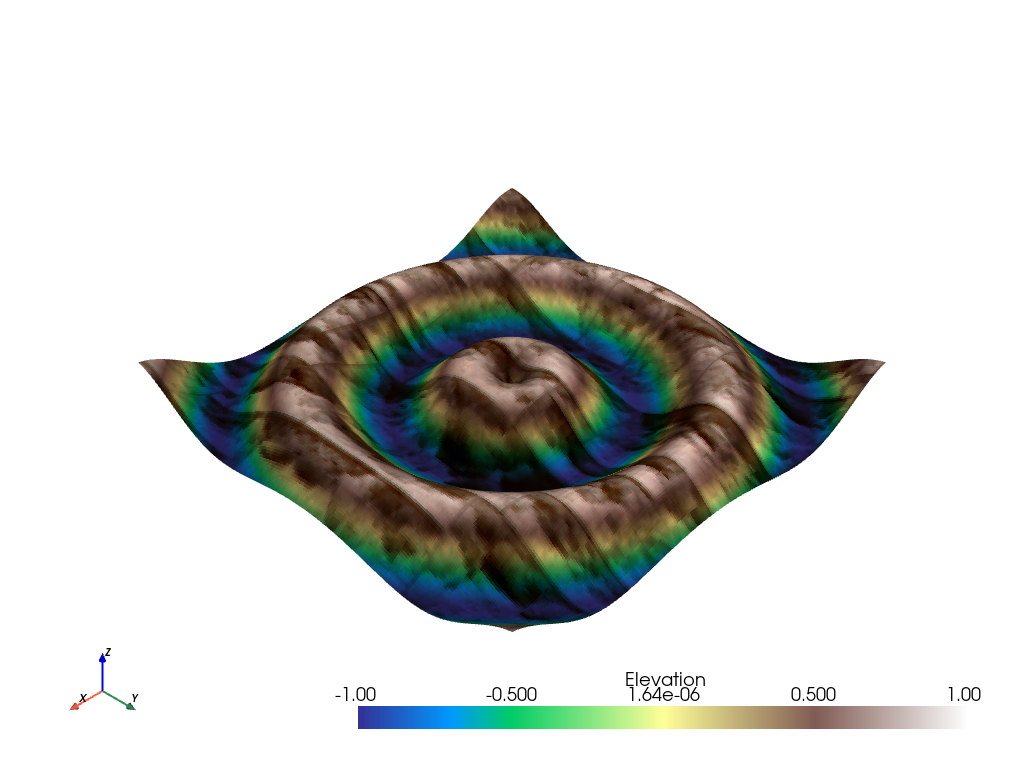

In [5]:
elevated = curvsurf.elevation()

elevated.plot(scalars='Elevation', cmap='terrain', texture=tex, interpolate_before_map=False)

Note that this process can be completed with any image texture!


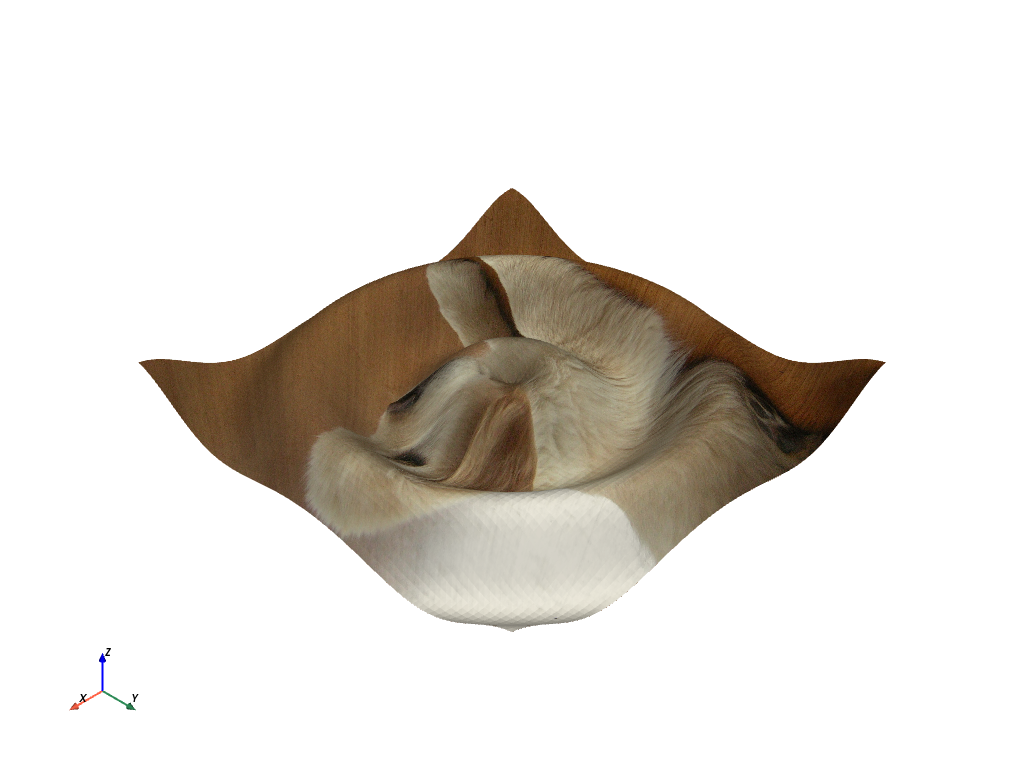

In [6]:
# use the puppy image
tex = examples.download_puppy_texture()
curvsurf.plot(texture=tex)

Textures from Files
===================

What about loading your own texture from an image? This is often most
easily done using the `pyvista.read_texture`{.interpreted-text
role="func"} function - simply pass an image file\'s path, and this
function with handle making a `vtkTexture` for you to use.


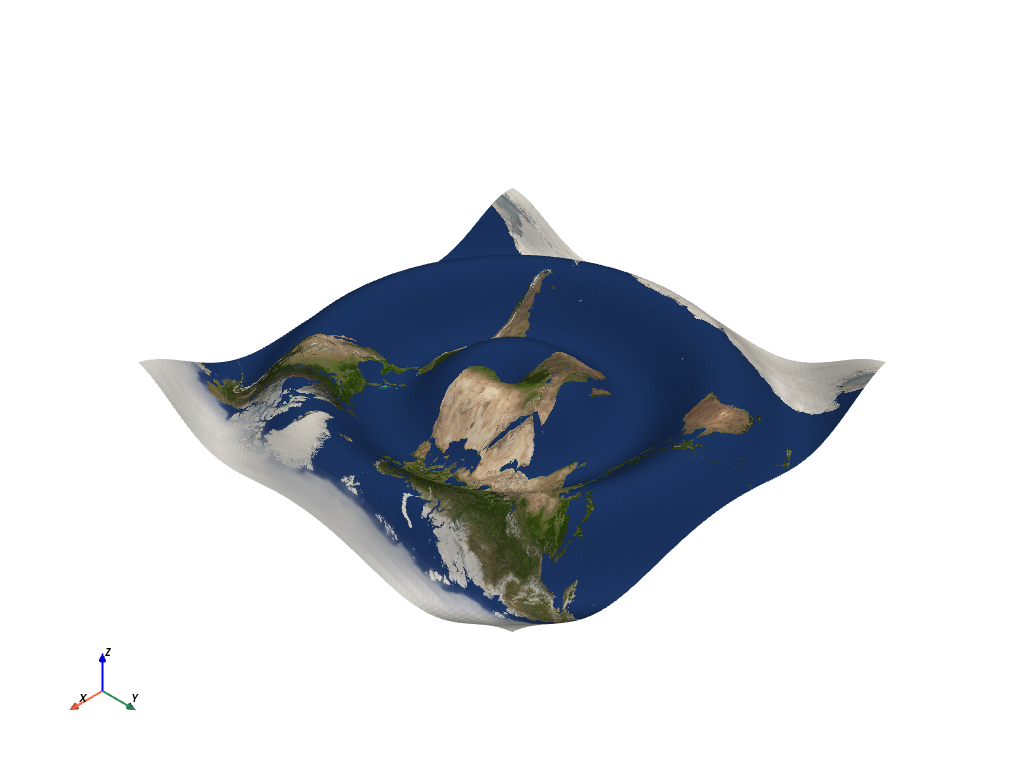

In [7]:
image_file = examples.mapfile
tex = pv.read_texture(image_file)
curvsurf.plot(texture=tex)

NumPy Arrays as Textures
========================

Want to use a programmatically built image?
`pyvista.UniformGrid`{.interpreted-text role="class"} objects can be
converted to textures using `pyvista.image_to_texture`{.interpreted-text
role="func"} and 3D NumPy (X by Y by RGB) arrays can be converted to
textures using `pyvista.numpy_to_texture`{.interpreted-text
role="func"}.


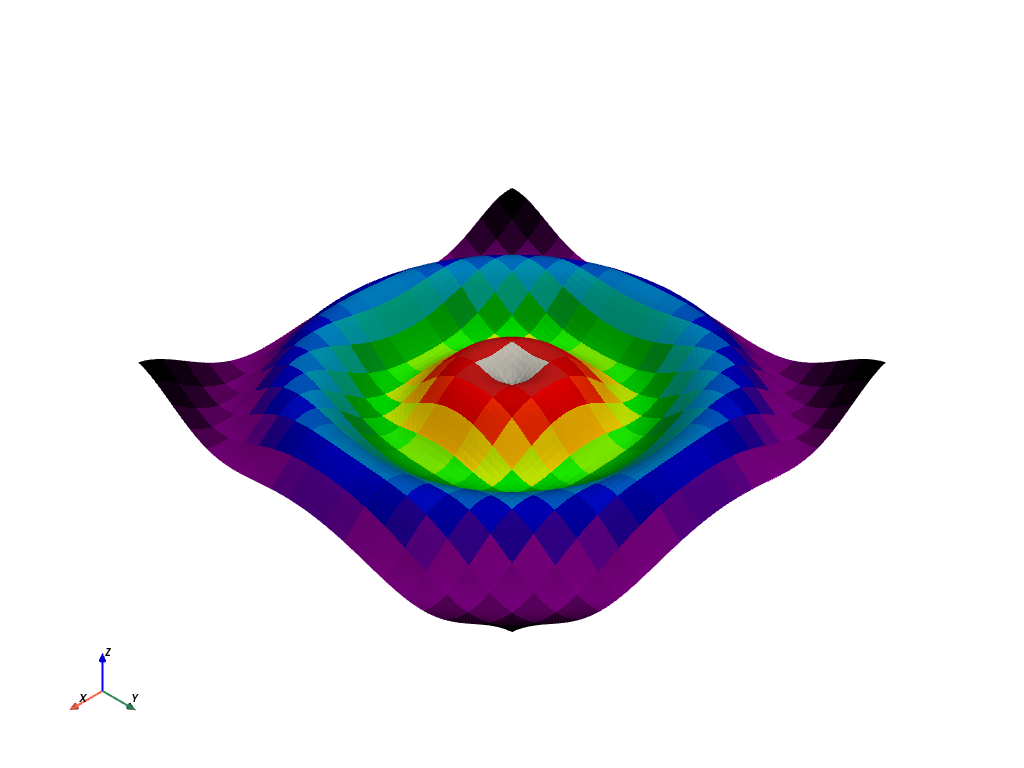

In [8]:
# create an image using numpy,
xx, yy = np.meshgrid(np.linspace(-200, 200, 20), np.linspace(-200, 200, 20))
A, b = 500, 100
zz = A * np.exp(-0.5 * ((xx / b) ** 2.0 + (yy / b) ** 2.0))

# Creating a custom RGB image
cmap = get_cmap("nipy_spectral")
norm = lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))
hue = norm(zz.ravel())
colors = (cmap(hue)[:, 0:3] * 255.0).astype(np.uint8)
image = colors.reshape((xx.shape[0], xx.shape[1], 3), order="F")

# Convert 3D numpy array to texture
tex = pv.numpy_to_texture(image)

# Render it!
curvsurf.plot(texture=tex)

Create a GIF Movie with updating textures
=========================================

Generate a moving gif from an active plotter with updating textures.


In [9]:
# Create a plotter object
plotter = pv.Plotter(notebook=False, off_screen=True)

# Open a gif
plotter.open_gif("texture.gif")

pts = curvsurf.points.copy()

# Update Z and write a frame for each updated position
nframe = 15
for phase in np.linspace(0, 2 * np.pi, nframe + 1)[:nframe]:

    # create an image using numpy,
    z = np.sin(r + phase)
    pts[:, -1] = z.ravel()

    # Creating a custom RGB image
    zz = A * np.exp(-0.5 * ((xx / b) ** 2.0 + (yy / b) ** 2.0))
    hue = norm(zz.ravel()) * 0.5 * (1.0 + np.sin(phase))
    colors = (cmap(hue)[:, 0:3] * 255.0).astype(np.uint8)
    image = colors.reshape((xx.shape[0], xx.shape[1], 3), order="F")

    # Convert 3D numpy array to texture
    tex = pv.numpy_to_texture(image)

    plotter.add_mesh(curvsurf, smooth_shading=True, texture=tex)
    plotter.update_coordinates(pts, render=False)

    # must update normals when smooth shading is enabled
    plotter.mesh.compute_normals(cell_normals=False, inplace=True)
    plotter.write_frame()
    plotter.clear()

# Closes and finalizes movie
plotter.close()

Textures with Transparency
==========================

Textures can also specify per-pixel opacity values. The image must
contain a 4th channel specifying the opacity value from 0
\[transparent\] to 255 \[fully visible\]. To enable this feature just
pass the opacity array as the 4th channel of the image as a 3
dimensional matrix with shape \[nrows, ncols, 4\]
`pyvista.numpy_to_texture`{.interpreted-text role="func"}.

Here we can download an image that has an alpha channel:


In [10]:
rgba = examples.download_rgba_texture()
rgba.n_components

4

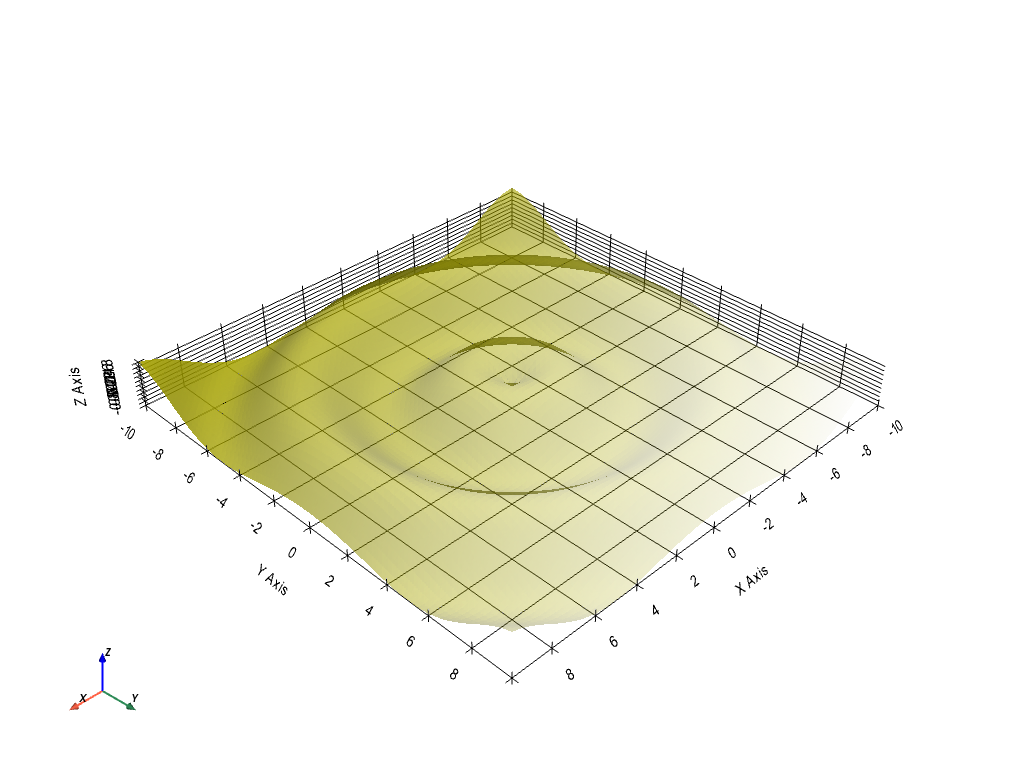

In [11]:
# Render it!
curvsurf.plot(texture=rgba, show_grid=True)

Repeating Textures
==================

What if you have a single texture that you\'d like to repeat across a
mesh? Simply define the texture coordinates for all nodes explicitly.

Here we create the texture coordinates to fill up the grid with several
mappings of a single texture. In order to do this we must define texture
coordinates outside of the typical `(0, 1)` range:


In [12]:
axial_num_puppies = 4
xc = np.linspace(0, axial_num_puppies, curvsurf.dimensions[0])
yc = np.linspace(0, axial_num_puppies, curvsurf.dimensions[1])

xxc, yyc = np.meshgrid(xc, yc)
puppy_coords = np.c_[yyc.ravel(), xxc.ravel()]

By defining texture coordinates that range `(0, 4)` on each axis, we
will produce 4 repetitions of the same texture on this mesh.

Then we must associate those texture coordinates with the mesh through
the `pyvista.DataSet.active_t_coords`{.interpreted-text role="attr"}
property.


In [13]:
curvsurf.active_t_coords = puppy_coords

Now display all the puppies!


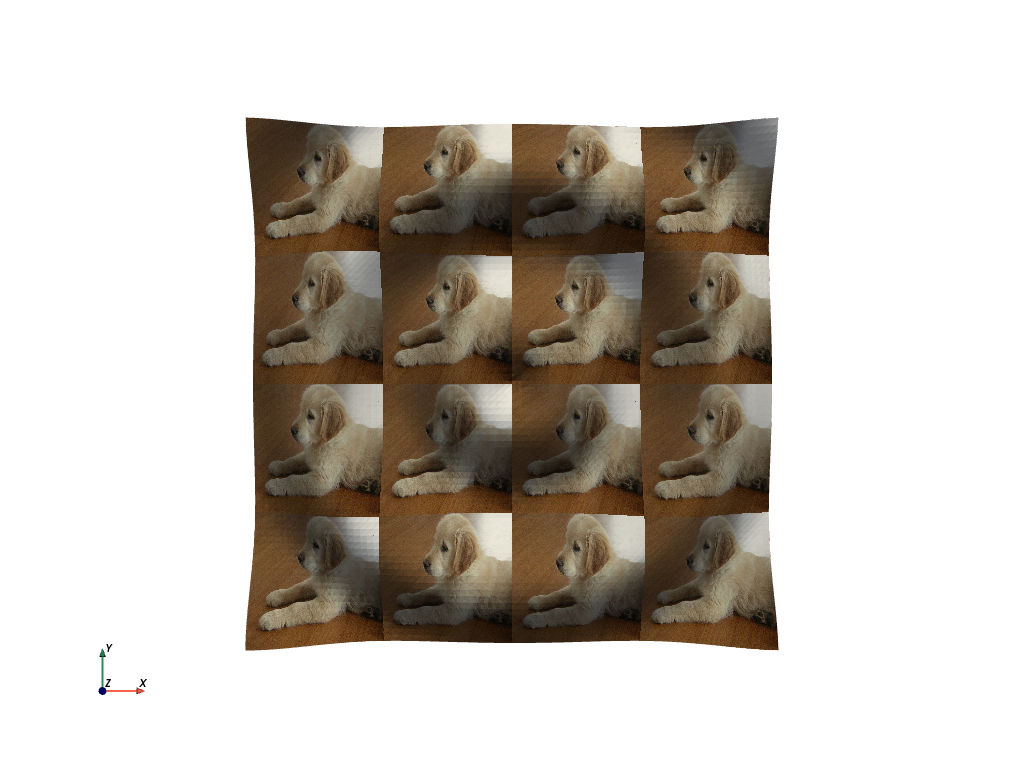

In [14]:
# use the puppy image
tex = examples.download_puppy_texture()
curvsurf.plot(texture=tex, cpos="xy")

Spherical Texture Coordinates
=============================

We have a built in convienance method for mapping textures to spherical
coordinate systems much like the planar mapping demoed above.


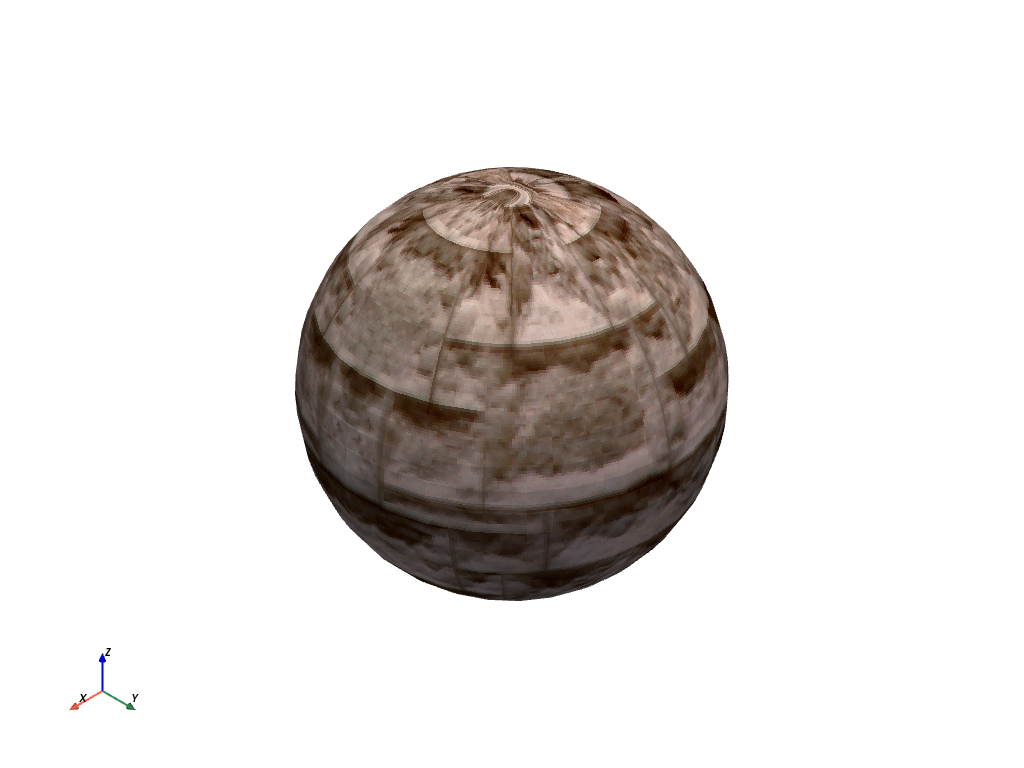

In [15]:
mesh = pv.Sphere()
tex = examples.download_masonry_texture()

mesh.texture_map_to_sphere(inplace=True)
mesh.plot(texture=tex)

The helper method above does not always produce the desired texture
coordinates, so sometimes it must be done manually. Here is a great,
user contributed example from [this support
issue](https://github.com/pyvista/pyvista-support/issues/257)

Manually create the texture coordinates for a globe map. First, we
create the mesh that will be used as the globe. Note the
[start\_theta]{.title-ref} for a slight overlappig


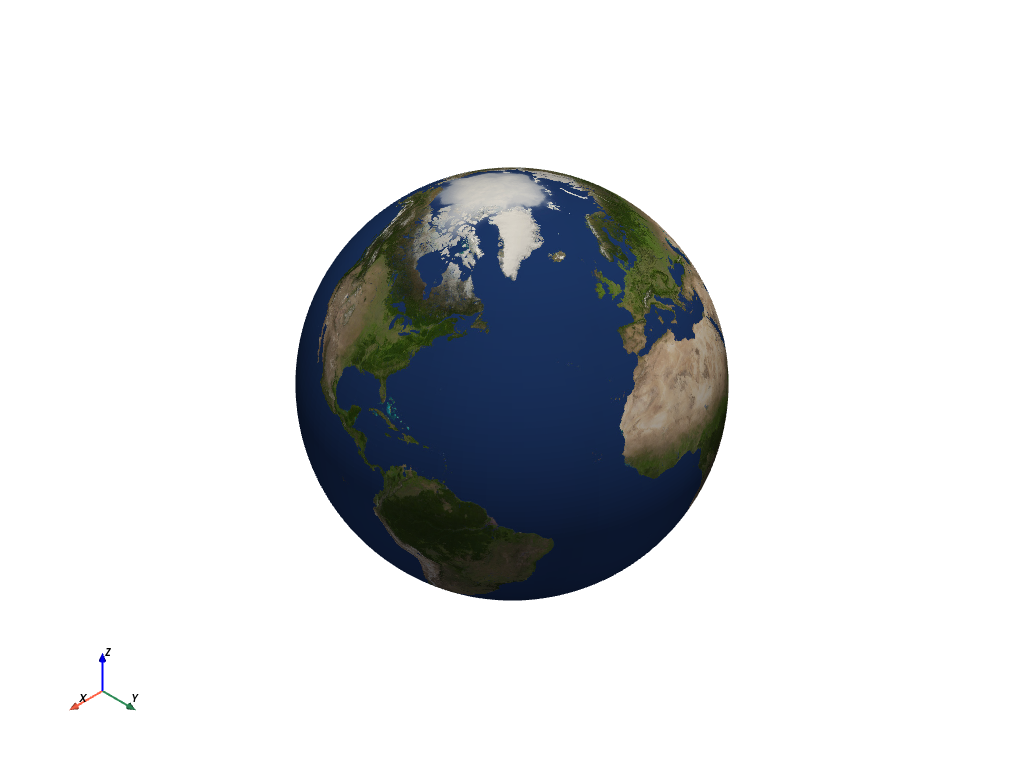

In [16]:
sphere = pv.Sphere(
    radius=1, theta_resolution=120, phi_resolution=120, start_theta=270.001, end_theta=270
)

# Initialize the texture coordinates array
sphere.active_t_coords = np.zeros((sphere.points.shape[0], 2))

# Populate by manually calculating
for i in range(sphere.points.shape[0]):
    sphere.active_t_coords[i] = [
        0.5 + np.arctan2(-sphere.points[i, 0], sphere.points[i, 1]) / (2 * np.pi),
        0.5 + np.arcsin(sphere.points[i, 2]) / np.pi,
    ]

# And let's display it with a world map
tex = examples.load_globe_texture()
sphere.plot(texture=tex)

In [17]:
tex = examples.download_puppy_texture()

ERROR:root:libjpeg could not read file: /Users/roland/Documents/test.jpeg
2022-09-24 18:03:46.702 (2503.626s) [          3BB842]      vtkJPEGReader.cxx:164    ERR| vtkJPEGReader (0x7fd781d14950): libjpeg could not read file: /Users/roland/Documents/test.jpeg
ERROR:root:libjpeg could not read file: /Users/roland/Documents/test.jpeg
2022-09-24 18:03:46.705 (2503.629s) [          3BB842]      vtkJPEGReader.cxx:348    ERR| vtkJPEGReader (0x7fd781d14950): libjpeg could not read file: /Users/roland/Documents/test.jpeg


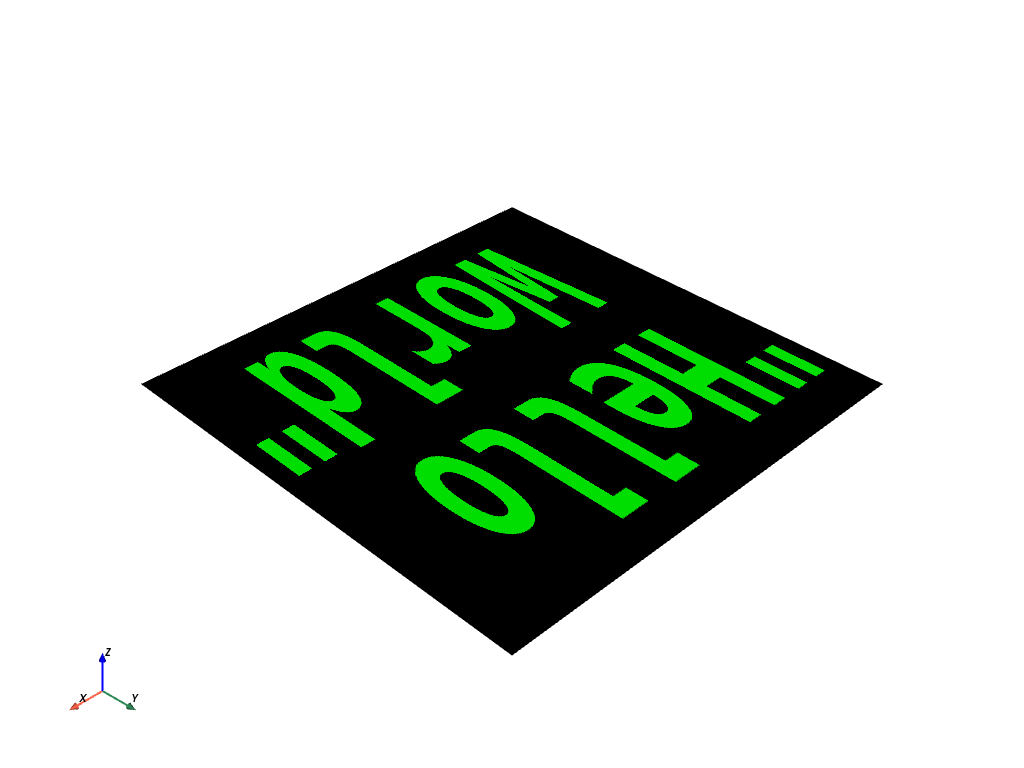

(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)0x7fd77a3a4ee0

In [72]:
reader  = vtk.vtkJPEGReader()
from pathlib import Path
cwd = Path().resolve()
dir_path = cwd
myfile = os.path.join(dir_path, 'test.jpeg')
# reader.SetFileName(myfile)
# mytexture = vtk.vtkTexture()
# mytexture.SetInputConnection(reader.GetOutputPort())
mytexture = pv.read_texture(myfile)
plane = pv.Plane()

# Initialize the texture coordinates array
plane.texture_map_to_plane(inplace=True)
plane.plot(texture=mytexture)
pl = pv.Plotter()
pl.add_mesh(plane,point_size=5.0, texture=mytexture , render_points_as_spheres=True,show_scalar_bar=False)

In [73]:
pl.export_gltf('planetest.gltf') 